### Going to try and use the loop version of Forward Euler to accomodate a non-constant blood flow


$$
A = v*dt/(2*dx)
$$

Needs to get updated for each $dt$

#### Non-Constant Blood Flow

To start, I am going to use a really simple model of blood flow just to get the code working. The model can updated later.

Use the following model:

$$
v(t) = v_{mean} + B * sin(\frac{2\pi f_{heart}}{60}t + \phi)
$$

Where,


$$
\begin{aligned}
v_{mean} &= 0.2 \frac{m}{s}\\
B &= \text{amplitude of fluctuation, assume to be 0.1 for now} \\
f_{heart} &= \text{resting heart rate, human average is between 60 and 100 bpm} \\
t &= \text{time in seconds} \\
\phi &= \text{phase shift (where in } f_{\text{heart}} \text{ cycle are you, assume to be zero)}
\end{aligned}
$$


In [9]:
import numpy as np
import warnings
import matplotlib.pyplot as plt

In [15]:
def v_t(t, f_heart=80, v_mean=0.2, B=0.1, phi=0):
    return v_mean + B*np.sin( ((2*np.pi*f_heart)/60)*t + phi)

Set Parameters

In [7]:
D = 0.1 # Diffusion coefficient
v_mean = 0.2 # Blood flow rate

Cf_desired = 1e-3 # Desired final concentrations

In [8]:
# Time parameters
Nt_gaps = 10000    # number of timesteps
T = 60             # final time 
Nt_points = Nt_gaps + 1
t = np.linspace(0.,T,Nt_points)  # times at each time step
dt = t[1] - t[0]


# x parameters
Nx_spaces = 1000;   # number of spaces in x
L1 = -10; # Distance behind 0 reference point
L2 = 25 # Distance in front  0 reference point
Nx_points = Nx_spaces + 1 
x = np.linspace(L1, L2, Nx_points)    # mesh points in space
dx = x[1] - x[0]

# Check our conditions
C = D*dt/(dx**2)
A = v_mean*dt/(2*dx)

print(f"Delta x = {round(dx, 4)}\nDelta t = {round(dt, 4)}\nC = {round(C, 4)}\nA = {round(A, 4)}")


if C >= 0.5:
    warnings.warn(f'C is greater than 0.5, C = {round(C,4)}')

if A > 1:
    warnings.warn(f'A is greater than 1, A = {round(A,4)}')

# Boundary conditions
# dirichlet
b0 = 0
bL = 0

Delta x = 0.035
Delta t = 0.006
C = 0.4898
A = 0.0171


### Plot blood flow, v as a function of time

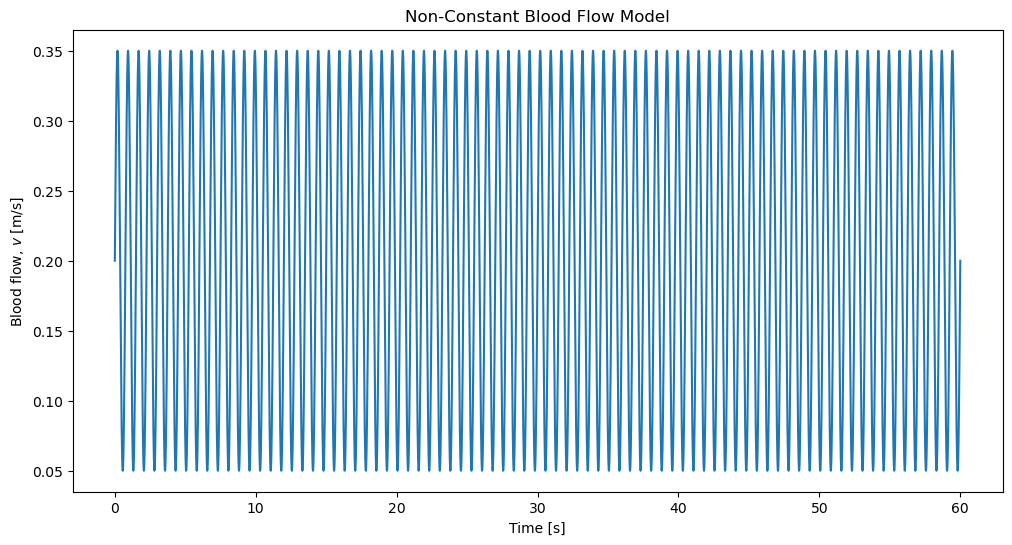

In [40]:
f_heart = 80

v = v_t(t, f_heart=f_heart, v_mean=v_mean, B=0.15)

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(t, v)

ax.set_xlabel('Time [s]')
ax.set_ylabel('Blood flow, $v$ [m/s]')

ax.set_title('Non-Constant Blood Flow Model')

plt.show()

Check the stability conditions

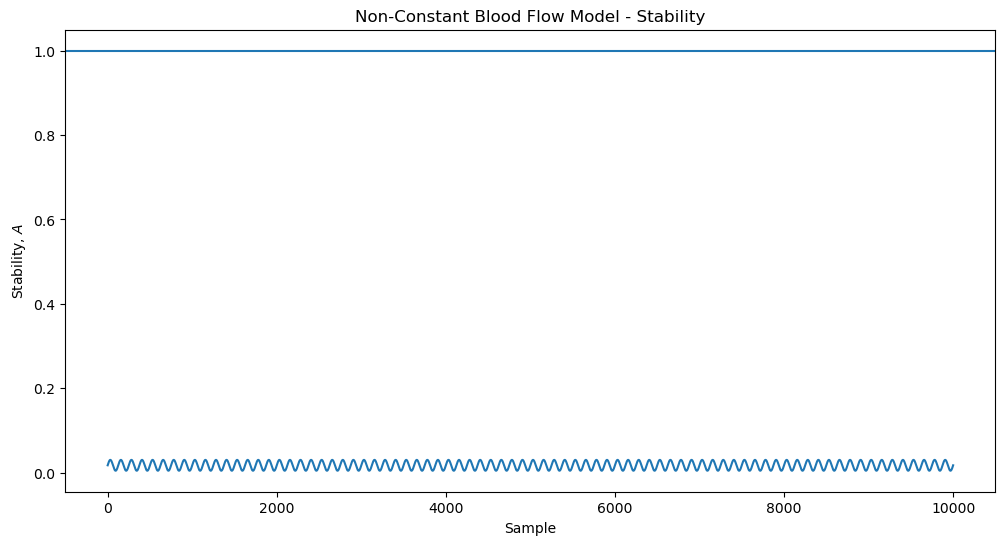

In [55]:
A_all = v*dt/(2*dx)

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(A_all)
ax.axhline(1)


ax.set_xlabel('Sample')
ax.set_ylabel('Stability, $A$')

ax.set_title('Non-Constant Blood Flow Model - Stability')

plt.show()


Go through Forward Euler steps with non-constant blood flow

In [31]:
def I(x, C0): # initial u(x,0)
    u = np.zeros_like(x)
    
    # where x is between 0 and 1, set to C0
    u[(x >= 0) & (x <= 1)] = C0
    return u

# Initial concentration
C0 = 1e-2

Solve Using Loops

In [41]:
def get_A(v, dt, dx):
    A = v*dt/(2*dx)
    return A

In [42]:
# # Solve
# Define the numerical solution 
# the first index is space and the second time
U = np.zeros((Nx_points, Nt_points))

# The initial condition
U[:,0] = I(x, C0)

# Enforce the boundary condition
U[0,0]  = b0 
U[-1,0] = bL

# Old/current values
u_old = I(x, C0)

# Initialize new matrix
u = np.zeros(Nx_points)

for n in range(1, Nt_points):
    u[0] = b0
    u[-1] = bL
    
    A_t = get_A(v[n], dt, dx)
    
    # apply forward Euler on the internal points, diffusion and advection
    for i in range(1, Nx_points-1):
        u[i] = u_old[i] + C *(u_old[i-1] - 2*u_old[i] + u_old[i+1]) - A_t*(u_old[i+1] - u_old[i-1])

    # update u_old before next step
    u_old[:] = u
    
    # copy into full storage
    U[:,n] = u;

In [35]:
def concentration_x_plot(x, U, t_str, ax):
    heart_loc = 13
    index_closest = (np.abs(x - heart_loc)).argmin()
    C_heart = U[index_closest]
    # print(index_closest)

    # Clear axes for next iteration of animation loop
    # ax.clear() 
    
    ax.plot(x, U, '.')
    
    ax.set_xlabel('x')
    ax.set_ylabel('concentration')
    ax.set_title(t_str)

    ax.set_xlim([0,15])
    
    ax.axvline(x=heart_loc, color='r', linestyle='--')
    
    ax.axhline(y=C_heart, color='b', linestyle='--', label= f'Cf = {round(C_heart, 4)}')
    ax.text(x=12, y=C_heart, s=f'Cf = {round(C_heart, 4)}', color='b', va='bottom', ha='left')
    # ax.legend()
    

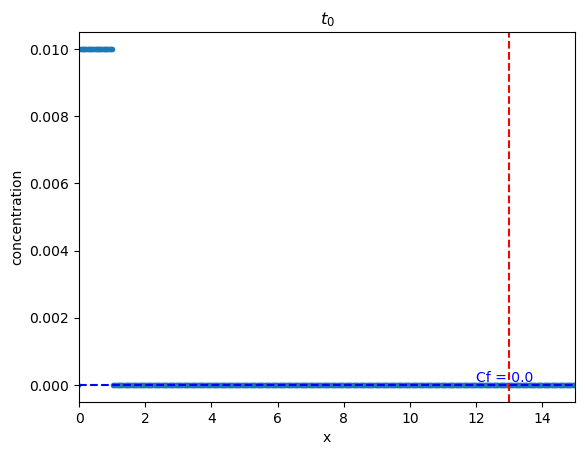

In [43]:
# Plot t = 0 (Initial condition)
fig, ax = plt.subplots()
concentration_x_plot(x, U[:,0], t_str='$t_{0}$', ax=ax)

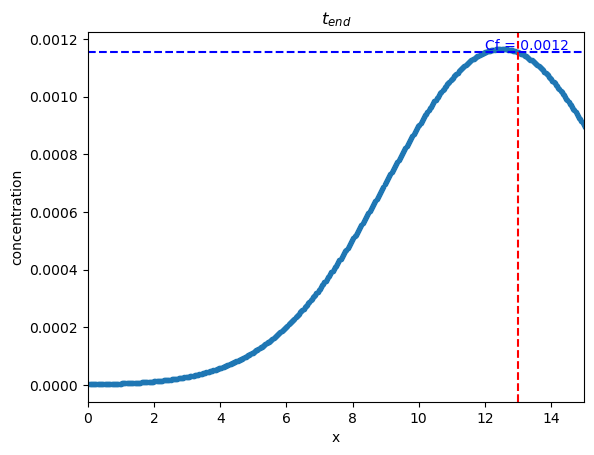

In [44]:
# Plot t = end (End of simulation)
fig, ax = plt.subplots()
concentration_x_plot(x, U[:,-1], t_str='$t_{end}$', ax=ax)

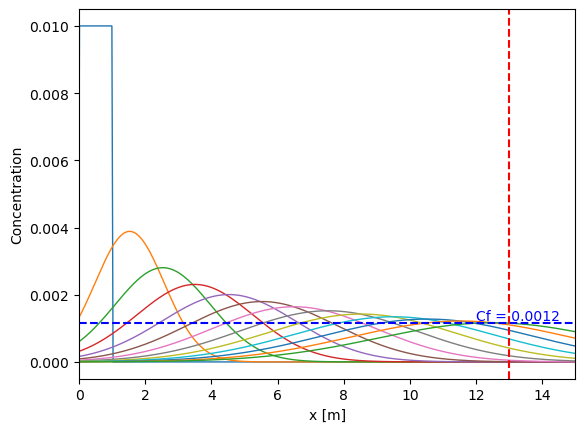

In [48]:
delta_t = 5
t_to_plot = np.arange(0, 60 + delta_t, delta_t)

heart_loc = 13
index_closest = (np.abs(x - heart_loc)).argmin()
C_heart = U[index_closest,-1]


fig, ax = plt.subplots()
for tt in t_to_plot:
    index_closest = (np.abs(t - tt)).argmin()
    ax.plot(x, U[:, index_closest], '-', linewidth = 1)
    
    if tt == 60:
        ax.axhline(y=C_heart, color='b', linestyle='--', label= f'Cf = {round(C_heart, 4)}')
        ax.text(x=12, y=C_heart, s=f'Cf = {round(C_heart, 4)}', color='b', va='bottom', ha='left')
    
ax.set_xlabel('x [m]')
ax.set_ylabel('Concentration')
ax.set_xlim([0,15])

ax.axvline(x=heart_loc, color='r', linestyle='--')

plt.show()

In [46]:
# Do this in case it happened to not go through x = 13 exactly
index_closest = (np.abs(x - 13)).argmin()

Cf = U[index_closest, -1]

print(f'Cf = {Cf}')

Cf = 0.0011539032457431862


## Now with matrices

We need to rebuild the $A$ matrix, *A_mat*, each time step to accomodate the changing blood flow

In [49]:
def build_A_mat(C, A, Nx_points):
    # Data structures for the linear system
    A_mat = np.zeros((Nx_points, Nx_points))

    for i in range(1, Nx_points-1):
        A_mat[i,i-1] = C + A
        A_mat[i,i+1] = C - A
        A_mat[i,i] = 1 - 2*C

    # implement the (constant-in-time) Dirichlet conditions
    A_mat[0,0] = 1
    A_mat[-1,-1] = 1
    
    return A_mat

In [56]:
# Initialize the A values which will be put into the matrix
A_all = v*dt/(2*dx)

# set up matrices for single time solutions and the full solution
u   = np.zeros(Nx_points)
u_old = np.zeros(Nx_points)

U = np.zeros((Nx_points,Nt_points))

# Set initial condition u(x,0) = I(x)
u_old = I(x, C0)

# initialise matrices for storing solutions
U[:,0] = u_old

# do timestepping 
for n in range(1, Nt_points):
    
    # A_t = get_A(v[n], dt, dx)
    
    A_mat = build_A_mat(C, A_all[n], Nx_points)
    
    # update u by solving the matrix system Au = b
    u_new = np.matmul(A_mat,u_old)
    
    # Update u_old before next step
    u_old = u_new
    U[:,n] = u_new

In [57]:
# Do this in case it happened to not go through x = 13 exactly
index_closest = (np.abs(x - 13)).argmin()

Cf = U[index_closest, -1]

print(f'Cf = {Cf}')

Cf = 0.0011539032457431857
